In [1]:
import time,json,os
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm_notebook
from common import preprocess,get_csv_files
from warnings import filterwarnings
import matplotlib.pyplot as plt
filterwarnings("ignore") 
np.set_printoptions(suppress=True)
pd.set_option('display.float_format',lambda x : '%.4f' % x)
plt.rcParams['axes.unicode_minus'] = False
%matplotlib inline

In [2]:
def show_heatmap(df):
    plt.style.use({'figure.figsize':(16, 6)})
    plt.ticklabel_format(style='plain',axis='both')
    cmap = sns.cubehelix_palette(start = 1, rot = 3, gamma=0.8, as_cmap = True)
    sns.heatmap(df, cmap = cmap, linewidths = 0.05,annot=False, fmt="g",annot_kws={"fontsize":16})
    plt.xticks(rotation=60)

In [3]:
def get_histogram(df):
    df_tmp = preprocess(df)
    del df_tmp['label']
    ret_df = pd.DataFrame()
    ret_series = pd.Series()
    for key in df_tmp.keys():
        normal = df_tmp[key]
        #hist, bin_edges = np.histogram(normal,bins=len(df.keys()), density=True)
        hist, bin_edges = np.histogram( normal,bins = len(df_tmp.keys()) )
        ret_df[key] = pd.Series(hist)
        ret_df[key] = (ret_df[key] - ret_df[key].min())/ (ret_df[key].max()-ret_df[key].min()) 
        #ret_df[key] = (ret_df[key] - ret_df[key].mean())/ ret_df[key].std() 
        ret_series = ret_series.append(ret_df[key], ignore_index=True)

    return ret_df.T,ret_series.reset_index(drop=True)

In [4]:
from scipy.spatial.distance import cosine
from scipy.stats import ks_2samp
from scipy.stats import wasserstein_distance
from scipy.stats import stats
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

class CJSimilarity(object):
    def __init__(self,list1,list2):
        self.m_list1 = list1
        self.m_list2 = list2
    
    #余弦距离（cosine）
    def Cosine(self):
        ret = cosine_similarity([self.m_list1, self.m_list2])
        return ret[0][1]
        return cosine(self.m_list1, self.m_list2)
    
    #皮尔森相关系数（pearson）,https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.pearsonr.html
    def Pearson(self):
        return stats.pearsonr(self.m_list1, self.m_list2)[0]
    
    #欧式距离
    def Euclidean(self):
        return np.linalg.norm(np.array(self.m_list1) - np.array(self.m_list2))

    #KS检验,(P越大，两个分布越相似)
    #P比指定的显著水平（假设为5%）小，则我们完全可以拒绝假设，即两个分布不服从同一分布。
    def KSTest(self):
        ret = ks_2samp(self.m_list1, self.m_list2)
        return ret[0],ret[1]
    
    #EDM距离
    def EDM(self):
        return wasserstein_distance(self.m_list1, self.m_list2)

In [5]:
csv_list = []
get_csv_files("/data/dataset/sample/",csv_list)
all_hist = {}
for fi in csv_list:
    dataset = os.path.splitext(os.path.basename(fi))[0]
    df = pd.read_csv(fi,index_col=0)
    print("generate histogram ",dataset,df.shape)
    df_hist,ds_hist = get_histogram(df)
    all_hist[dataset] = {}
    all_hist[dataset]['df_hist'] = df_hist
    all_hist[dataset]['ds_hist'] = ds_hist

generate histogram  base-3-2-test-1 (50000, 43)
generate histogram  base-0-1-test-1 (46104, 43)
generate histogram  base-1-1-test-2 (250000, 43)
generate histogram  base-3-1-test-2 (250000, 43)
generate histogram  base-0-1-test-2 (230522, 43)
generate histogram  base-1-1-train-1 (250000, 43)
generate histogram  base-1-1-test-3 (500000, 43)
generate histogram  base-1-1-test-1 (50000, 43)
generate histogram  base-3-1-train-1 (250000, 43)
generate histogram  base-3-2-test-2 (250000, 43)
generate histogram  base-0-1-test-3 (461043, 43)
generate histogram  base-3-1-test-3 (500000, 43)
generate histogram  base-3-2-train-1 (250000, 43)
generate histogram  base-3-2-test-3 (500000, 43)
generate histogram  base-0-1-train-1 (230522, 43)
generate histogram  base-3-1-test-1 (50000, 43)


In [6]:
all_similarity = []
for d1 in all_hist:
    for d2 in all_hist:
        s = CJSimilarity(all_hist[d1]['ds_hist'].tolist(),all_hist[d2]['ds_hist'].tolist())
        tmp = {}
        tmp['D1'] = d1
        tmp['D2'] = d2
        tmp['Cosine'] = s.Cosine()
        tmp['Pearson'] = s.Pearson()
        tmp['Euclidean'] = s.Euclidean()
        tmp['EDM'] = s.EDM()
        tmp['KS'] = s.KSTest()[1]
        all_similarity.append(tmp)
df_similarity = pd.DataFrame(all_similarity)
df_similarity.to_csv("/data/dataset/analyse/similarity.csv")

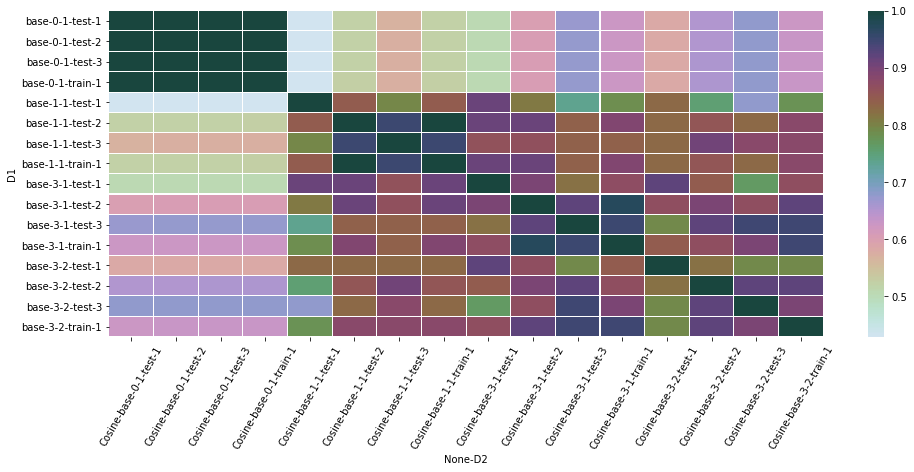

In [7]:
pt = df_similarity.pivot_table(index='D1', columns=['D2'],  values=['Cosine'],aggfunc=np.mean)
show_heatmap(pt)

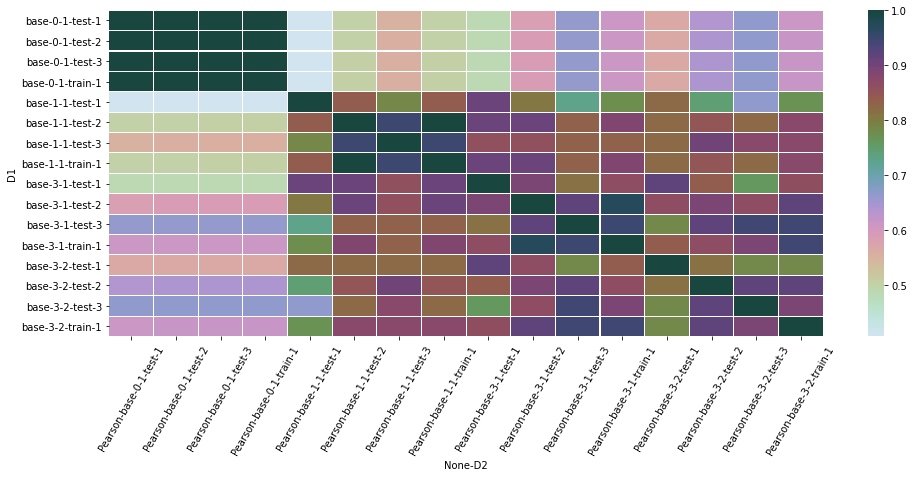

In [8]:
pt = df_similarity.pivot_table(index='D1', columns=['D2'],  values=['Pearson'],aggfunc=np.mean)
show_heatmap(pt)

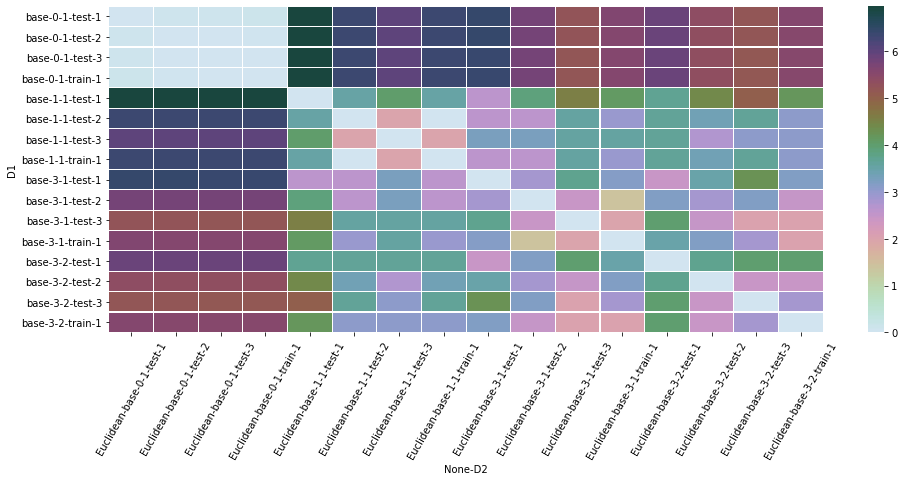

In [9]:
pt = df_similarity.pivot_table(index='D1', columns=['D2'],  values=['Euclidean'],aggfunc=np.mean)
show_heatmap(pt)

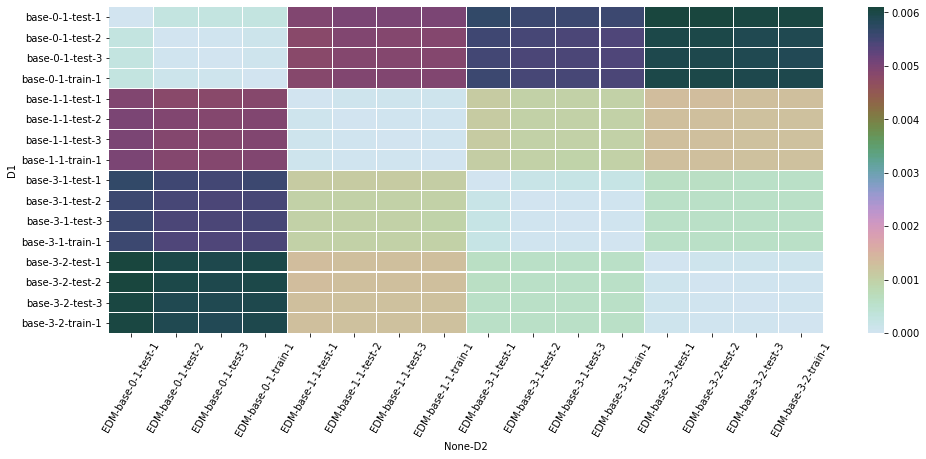

In [10]:
pt = df_similarity.pivot_table(index='D1', columns=['D2'],  values=['EDM'],aggfunc=np.mean)
show_heatmap(pt)

In [11]:
pt.to_csv("./test.csv")

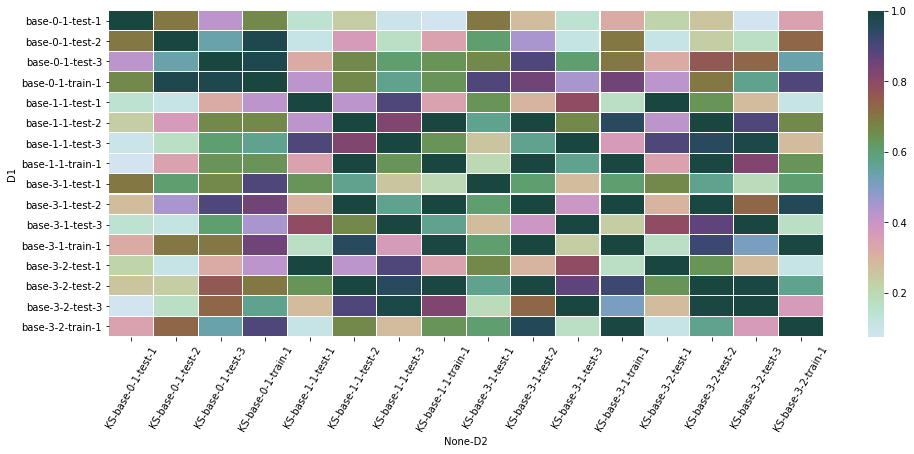

In [12]:
pt = df_similarity.pivot_table(index='D1', columns=['D2'],  values=['KS'],aggfunc=np.mean)
show_heatmap(pt)

In [13]:
pt

KS                                  \
D2               base-0-1-test-1 base-0-1-test-2 base-0-1-test-3   
D1                                                                 
base-0-1-test-1           1.0000          0.6996          0.4223   
base-0-1-test-2           0.6996          1.0000          0.5400   
base-0-1-test-3           0.4223          0.5400          1.0000   
base-0-1-train-1          0.6675          0.9765          0.9765   
base-1-1-test-1           0.1442          0.1101          0.3208   
base-1-1-test-2           0.2373          0.3694          0.6675   
base-1-1-test-3           0.1004          0.1713          0.6031   
base-1-1-train-1          0.0753          0.3445          0.6352   
base-3-1-test-1           0.6996          0.6031          0.6675   
base-3-1-test-2           0.2768          0.4504          0.8977   
base-3-1-test-3           0.1442          0.1206          0.6031   
base-3-1-train-1          0.3208          0.6996          0.6996   
base-3-2-test-1           0.2192          0.1101          0.3208   
base-3-2-test-2           0.2565          0.2373          0.7624   
base-3-2-test-3           0.0753          0.1713          0.7313   
base-3-2-train-1          0.3445          0.7313          0.5400   

                                                                   \
D2               base-0-1-train-1 base-1-1-test-1 base-1-1-test-2   
D1                                                                  
base-0-1-test-1            0.6675          0.1442          0.2373   
base-0-1-test-2            0.9765          0.1101          0.3694   
base-0-1-test-3            0.9765          0.3208          0.6675   
base-0-1-train-1           1.0000          0.4223          0.6675   
base-1-1-test-1            0.4223          1.0000          0.4223   
base-1-1-test-2            0.6675          0.4223          1.0000   
base-1-1-test-3            0.5713          0.8977          0.8215   
base-1-1-train-1           0.6352          0.3445          0.9999   
base-3-1-test-1            0.8977          0.6352          0.5713   
base-3-1-test-2            0.8488          0.2982          0.9986   
base-3-1-test-3            0.4504          0.7926          0.6675   
base-3-1-train-1           0.8488          0.1713          0.9529   
base-3-2-test-1            0.4223          1.0000          0.4223   
base-3-2-test-2            0.6996          0.6352          1.0000   
base-3-2-test-3            0.5713          0.2768          0.8977   
base-3-2-train-1           0.8977          0.1101          0.6675   

                                                                   \
D2               base-1-1-test-3 base-1-1-train-1 base-3-1-test-1   
D1                                                                  
base-0-1-test-1           0.1004           0.0753          0.6996   
base-0-1-test-2           0.1713           0.3445          0.6031   
base-0-1-test-3           0.6031           0.6352          0.6675   
base-0-1-train-1          0.5713           0.6352          0.8977   
base-1-1-test-1           0.8977           0.3445          0.6352   
base-1-1-test-2           0.8215           0.9999          0.5713   
base-1-1-test-3           1.0000           0.6352          0.2565   
base-1-1-train-1          0.6352           1.0000          0.2022   
base-3-1-test-1           0.2565           0.2022          1.0000   
base-3-1-test-2           0.5713           0.9971          0.6031   
base-3-1-test-3           0.9999           0.5713          0.2768   
base-3-1-train-1          0.3694           0.9904          0.6031   
base-3-2-test-1           0.8977           0.3445          0.6675   
base-3-2-test-2           0.9529           0.9945          0.5713   
base-3-2-test-3           0.9845           0.8215          0.1862   
base-3-2-train-1          0.2768           0.6352          0.6031   

                                                                   \
D2               base-3-1-test-2 base-3-1-te